In [1]:
import pandas as pd
import talib as tb
import matplotlib.pyplot as plt
import bt

from matplotlib.pyplot import figure

In [2]:
hedge_df = pd.read_excel(r'I.xlsx', sheet_name='Sheet1')
hedge_df['date'] = pd.to_datetime(hedge_df['date'])
hedge_df.set_index('date', inplace=True)
hedge_df

,open,high,low,close,volume
date,,,,,
2019-01-02 09:01:00,496.5,496.5,492.0,493.5,21786.0
2019-01-02 09:02:00,493.5,494.5,492.5,493.0,9238.0
2019-01-02 09:03:00,493.0,493.5,492.5,493.5,5824.0
2019-01-02 09:04:00,494.0,494.0,493.0,493.0,5762.0
2019-01-02 09:05:00,492.5,493.5,492.5,493.5,2572.0
...,...,...,...,...,...
2021-08-30 22:56:00,838.0,840.5,838.0,839.0,2173.0
2021-08-30 22:57:00,839.5,839.5,838.5,839.0,534.0
2021-08-30 22:58:00,839.0,839.0,838.5,839.0,408.0


In [3]:
main_df = pd.read_excel('RB(main).xlsx', sheet_name='Sheet1')
main_df['date'] = pd.to_datetime(main_df['date'])
main_df.set_index('date', inplace=True)
main_df

,open,high,low,close,volume
date,,,,,
2019-01-02 09:01:00,3398.0,3405.0,3389.0,3400.0,79572.0
2019-01-02 09:02:00,3401.0,3430.0,3401.0,3409.0,88858.0
2019-01-02 09:03:00,3410.0,3414.0,3409.0,3413.0,22584.0
2019-01-02 09:04:00,3412.0,3413.0,3403.0,3405.0,17688.0
2019-01-02 09:05:00,3404.0,3409.0,3404.0,3406.0,15522.0
...,...,...,...,...,...
2021-08-30 22:56:00,5347.0,5351.0,5347.0,5351.0,3294.0
2021-08-30 22:57:00,5351.0,5351.0,5346.0,5347.0,2165.0
2021-08-30 22:58:00,5347.0,5347.0,5345.0,5346.0,1223.0


<AxesSubplot:>

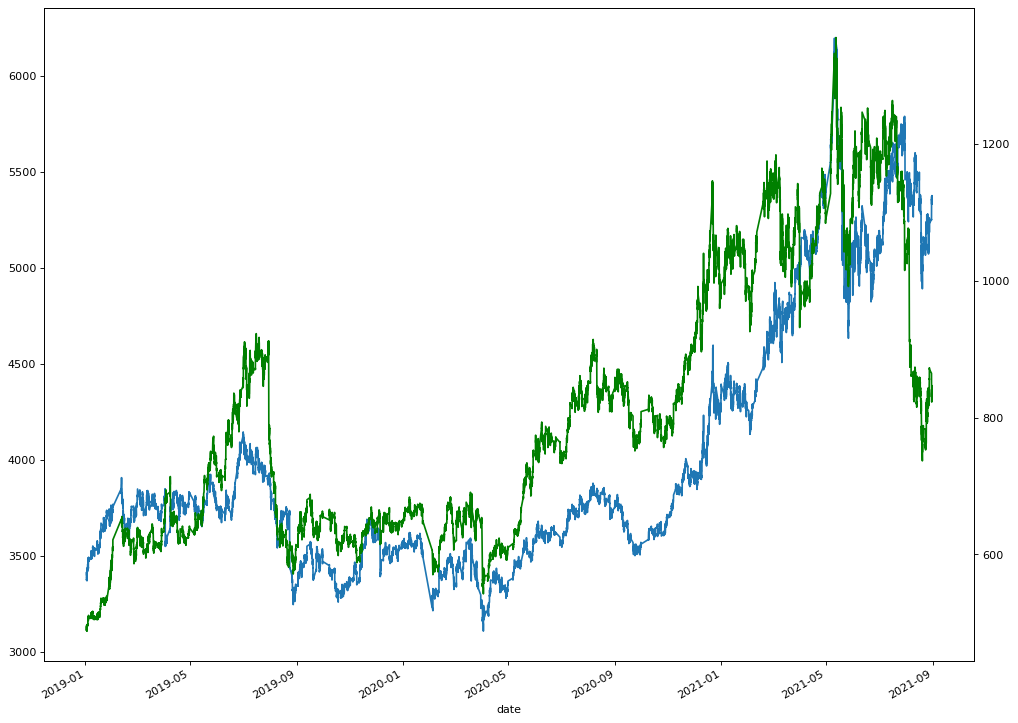

In [4]:
figure(figsize=(15, 12), dpi=80)

main_df['close'].plot()
hedge_df['close'].plot(secondary_y=True, style="g")

In [5]:
def resample(freq, dataframe: pd.DataFrame) -> pd.DataFrame:
  return dataframe.groupby(pd.Grouper(freq=freq)).agg(
      {'open':'first', 
       'close':'last', 
       'high':'max', 
       'low':'min', 
       'volume': 'sum'
      }
  )

<AxesSubplot:>

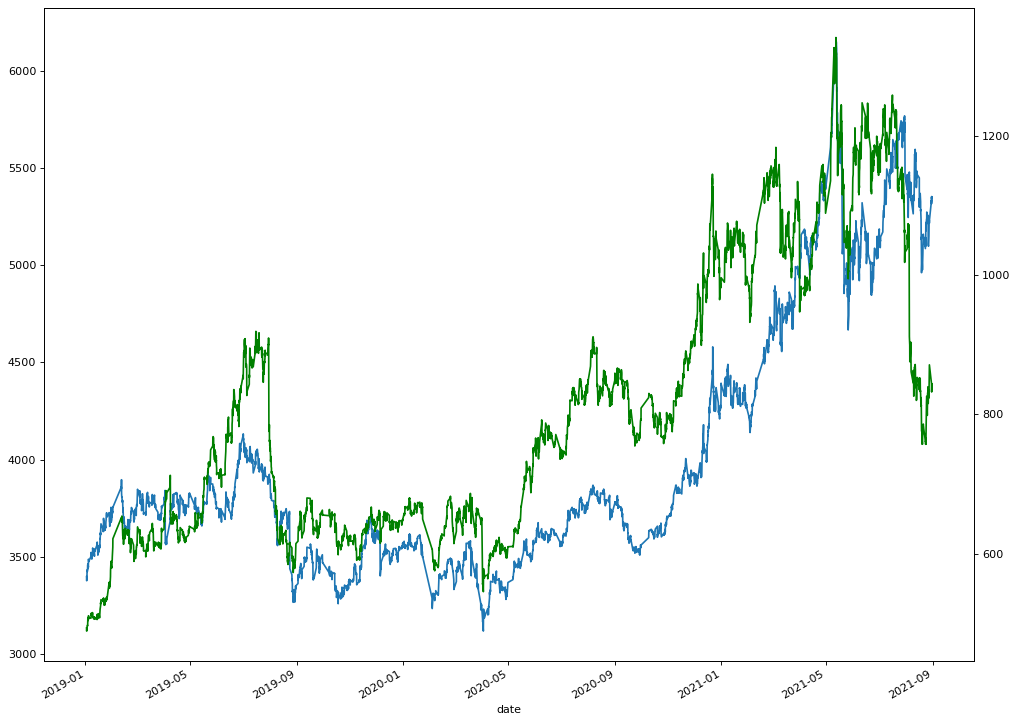

In [6]:
main_H1 = resample('1h', main_df).dropna()
hedge_H1 = resample('1h', hedge_df).dropna()

figure(figsize=(15, 12), dpi=80)

main_H1['close'].plot()
hedge_H1['close'].plot(secondary_y=True, style="g")

<AxesSubplot:>

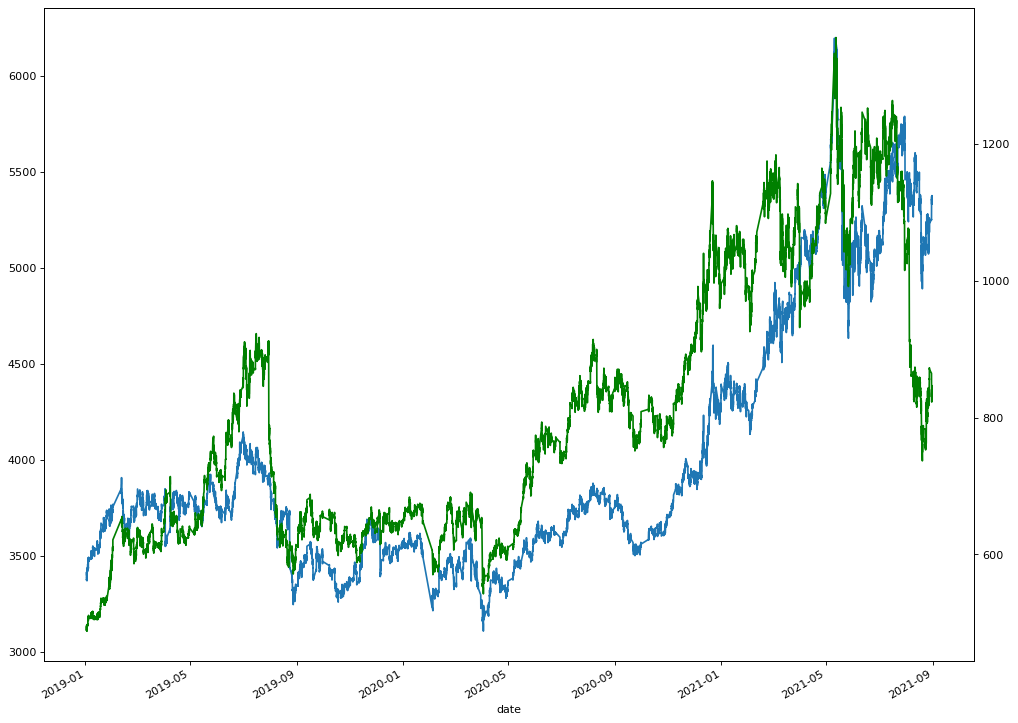

In [7]:
main_M1 = resample('1min', main_df).dropna()
hedge_M1 = resample('1min', hedge_df).dropna()

figure(figsize=(15, 12), dpi=80)

main_M1['close'].plot()
hedge_M1['close'].plot(secondary_y=True, style="g")

In [8]:
big_bias = tb.RSI(main_H1['close'], timeperiod=28) - tb.RSI(hedge_H1['close'], timeperiod=28)
big_bias

date
2019-01-02 09:00:00         NaN
2019-01-02 10:00:00         NaN
2019-01-02 11:00:00         NaN
2019-01-02 13:00:00         NaN
2019-01-02 14:00:00         NaN
                         ...   
2021-08-30 14:00:00    7.748854
2021-08-30 15:00:00    7.913996
2021-08-30 21:00:00    5.115426
2021-08-30 22:00:00    5.911820
2021-08-30 23:00:00    6.058742
Length: 5595, dtype: float64

In [9]:
small_bias = tb.RSI(main_M1['close'], timeperiod=28) - tb.RSI(hedge_M1['close'], timeperiod=28)
small_bias

date
2019-01-02 09:01:00         NaN
2019-01-02 09:02:00         NaN
2019-01-02 09:03:00         NaN
2019-01-02 09:04:00         NaN
2019-01-02 09:05:00         NaN
                         ...   
2021-08-30 22:56:00   -0.536420
2021-08-30 22:57:00   -2.949632
2021-08-30 22:58:00   -3.537839
2021-08-30 22:59:00   -6.135024
2021-08-30 23:00:00   -5.182109
Length: 214080, dtype: float64

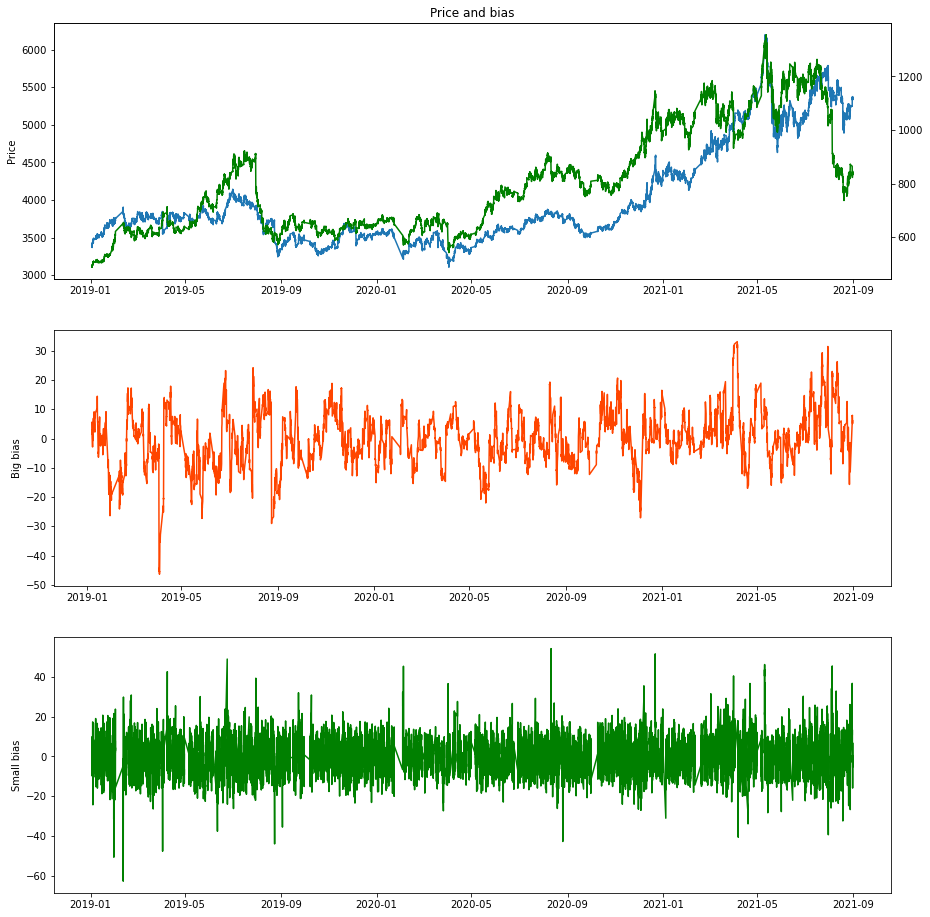

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(15,16))

ax1.set_ylabel('Price')
ax1.plot(main_df['close'])
ax1_t = ax1.twinx()
ax1_t.plot(hedge_df['close'], color='g')

ax2.set_ylabel('Big bias')
ax2.plot(big_bias, color='orangered')
ax3.set_ylabel('Small bias')
ax3.plot(small_bias, color='green')


ax1.set_title('Price and bias')

plt.show()

In [11]:
threshold_min = 7
threshold_max = 200

<AxesSubplot:>

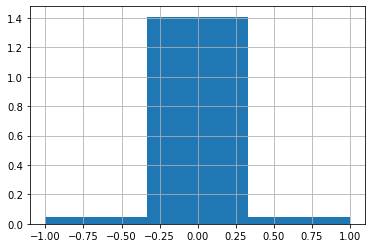

In [12]:
signal = big_bias.copy()
signal[:] = 0

signal[(big_bias > 0) & (big_bias > threshold_min) & (small_bias > threshold_min)] = 1

signal[(big_bias < 0) & 
       (big_bias < -threshold_min) &
       (big_bias > -threshold_max) &
       (small_bias < 0) &
       (small_bias < -threshold_min)] = -1

signal.hist(density=True, bins=3)

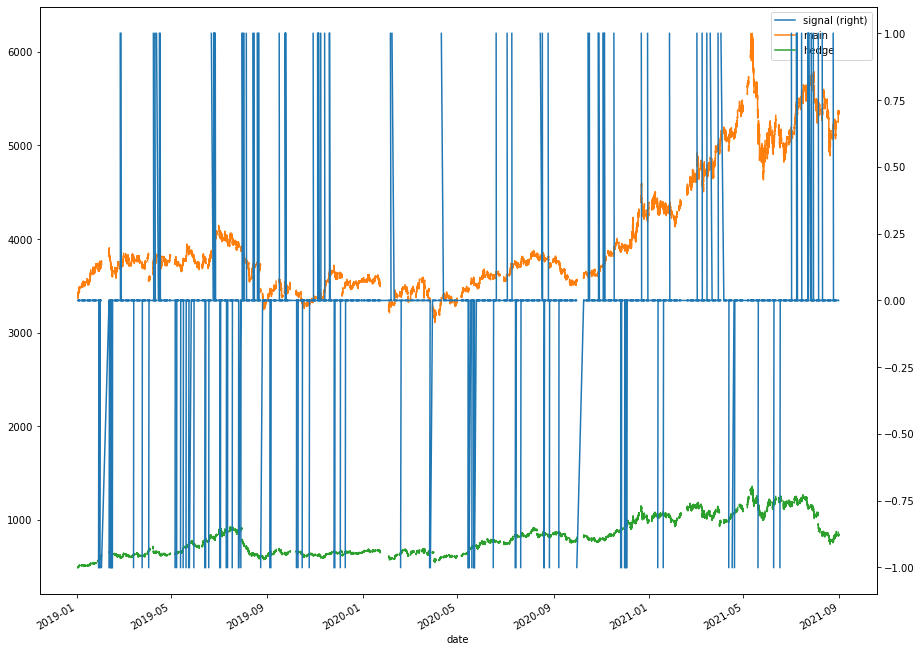

In [13]:
combined_df = bt.merge(signal, main_df['close'], hedge_df['close'])

combined_df.columns = ['signal', 'main', 'hedge']
combined_df.plot(secondary_y=['signal'], figsize=(15, 12))

plt.show()

In [48]:
scale_main = 1.4
scale_hedge = 1

In [49]:
pnl = signal.copy()
pnl[:] = 0

In [50]:
main_shifted = main_H1.shift(1)
hedge_shifted = hedge_H1.shift(1)

pnl_curr = 0

for index, sig_val in signal.items():
    if sig_val == -1:
        pnl_curr += scale_main * (main_shifted.loc[index, 'close'] - main_H1.loc[index, 'close'])
        pnl_curr += scale_hedge * (hedge_H1.loc[index, 'close'] - hedge_shifted.loc[index, 'close'])
    elif sig_val == +1:
        pnl_curr -= scale_main * (main_shifted.loc[index, 'close'] - main_H1.loc[index, 'close'])
        pnl_curr -= scale_hedge * (hedge_H1.loc[index, 'close'] - hedge_shifted.loc[index, 'close'])

    pnl.loc[index] = pnl_curr

In [51]:
baseline_pnl = signal.copy()
baseline_pnl[:] = 0

for index, sig_val in signal.items():
    baseline_pnl.loc[index] = main_H1.loc[index, 'close'] - main_H1.iloc[1]['close']

<AxesSubplot:xlabel='date'>

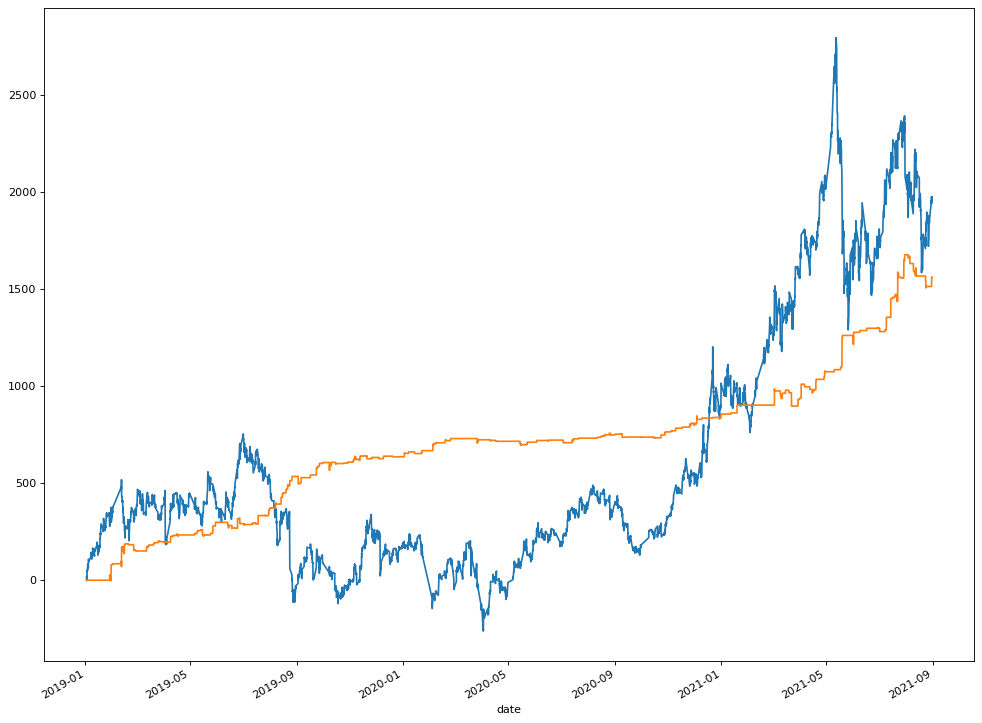

In [52]:
figure(figsize=(15, 12), dpi=80)

baseline_pnl.plot()
pnl.plot()